# Compute Measurements

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, which is hyperparameter tuned.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

var_names, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

path_svd = './OfflineSVD/'
var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))

Let us import the mesh to extract the positions of the reflector region

In [2]:
from mesh import *
from dolfinx.fem import Function, FunctionSpace, locate_dofs_topological
import ufl
from IPython.display import clear_output

domain, ct, ft = evol_mesh()

fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]*(len(var_names)-1)
fun_spaces.append(FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1)))

measured_field = 0

clear_output()
print('The observable field is '+var_names[measured_field])

reflector_mark = 20
refl_tags = locate_dofs_topological(fun_spaces[measured_field], ct.dim, ct.find(reflector_mark))
Nh = fun_spaces[measured_field].tabulate_dof_coordinates().shape[0]

The observable field is flux1


## Generation of the measurement data

Generation of the sensors as linear functionals
\begin{equation*}
    v_m(u(\mathbf{x});\,\mathbf{x}_m,\,s)=\int_\Omega u(\mathbf{x})\cdot \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\,d\Omega
\end{equation*}
given $\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)$ a kernel function which depends on the distance from the centre $\mathbf{x}_m$ (position of the physical sensor) and the point spread $s$.

The kernel is defined as
\begin{equation*}
    \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right) =
    \frac{e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}}{\displaystyle\int_\Omega e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}\,d\Omega}
\end{equation*}

In [3]:
from pyforce.offline.sensors import gaussian_sensors
from pyforce.tools.backends import LoopProgress

point_spread = 0.025
sens_class = gaussian_sensors(domain, fun_spaces[measured_field], point_spread)

num_sensors = 3 
sensor_locations = [0,1,2]

n_configurations = 30
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

bar = LoopProgress('Creating sensors', final = n_configurations)
for kk in range(n_configurations):
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(Nh, size=num_sensors, replace=False), dtype=int)
    # idx_sensor_locations[:, kk] = np.asarray(np.random.choice(refl_tags, size=num_sensors, replace=False), dtype=int)
    sensors.append(sens_class.create(fun_spaces[measured_field].tabulate_dof_coordinates()[idx_sensor_locations[:,kk]], sampleEvery=1, verbose=False))
    
    bar.update(1)

Creating sensors: 30.000 / 30.00 - 0.051 s/it


Now let us define the time-series measurements using $v_m$

In [4]:
from pyforce.tools.write_read import ImportH5

path_snaps = './dolfinx_data/'
measured_snap = ImportH5(fun_spaces[measured_field], path_snaps+var_names[measured_field], var_names[measured_field], verbose=False)[0]

snap_measurements = np.zeros((num_sensors, len(measured_snap), n_configurations))

bar = LoopProgress('Creating sensors', final = n_configurations)
for kk in range(n_configurations):
    for tt in range(len(measured_snap)):
        snap_measurements[:, tt, kk] = sens_class.action(measured_snap(tt) / rescaling_snaps[measured_field], sensors[kk])
        # snap_measurements[:, tt, kk] = measured_snap(tt)[idx_sensor_locations[:, kk]] / rescaling_snaps[measured_field]
        
    bar.update(1)

Creating sensors: 30.000 / 30.00 - 8.751 s/it


## Preprocessing the data
In this section, the measurements are upscaled

In [5]:
from scipy.interpolate import CubicSpline

t = times
newnt = 2000
new_t = np.linspace(t[0], t[-1], newnt)

noise_value = 5/100
Xsensor = np.zeros((num_sensors, newnt, n_configurations))

for kk in range(n_configurations):
    for j in range(num_sensors):
        
        measure = snap_measurements[j, :, kk]
        
        spline = CubicSpline(t, measure)
        Xsensor[j, :, kk] = spline(new_t) * (1 + np.random.normal(scale=noise_value, size=new_t.shape))

Let us some configurations

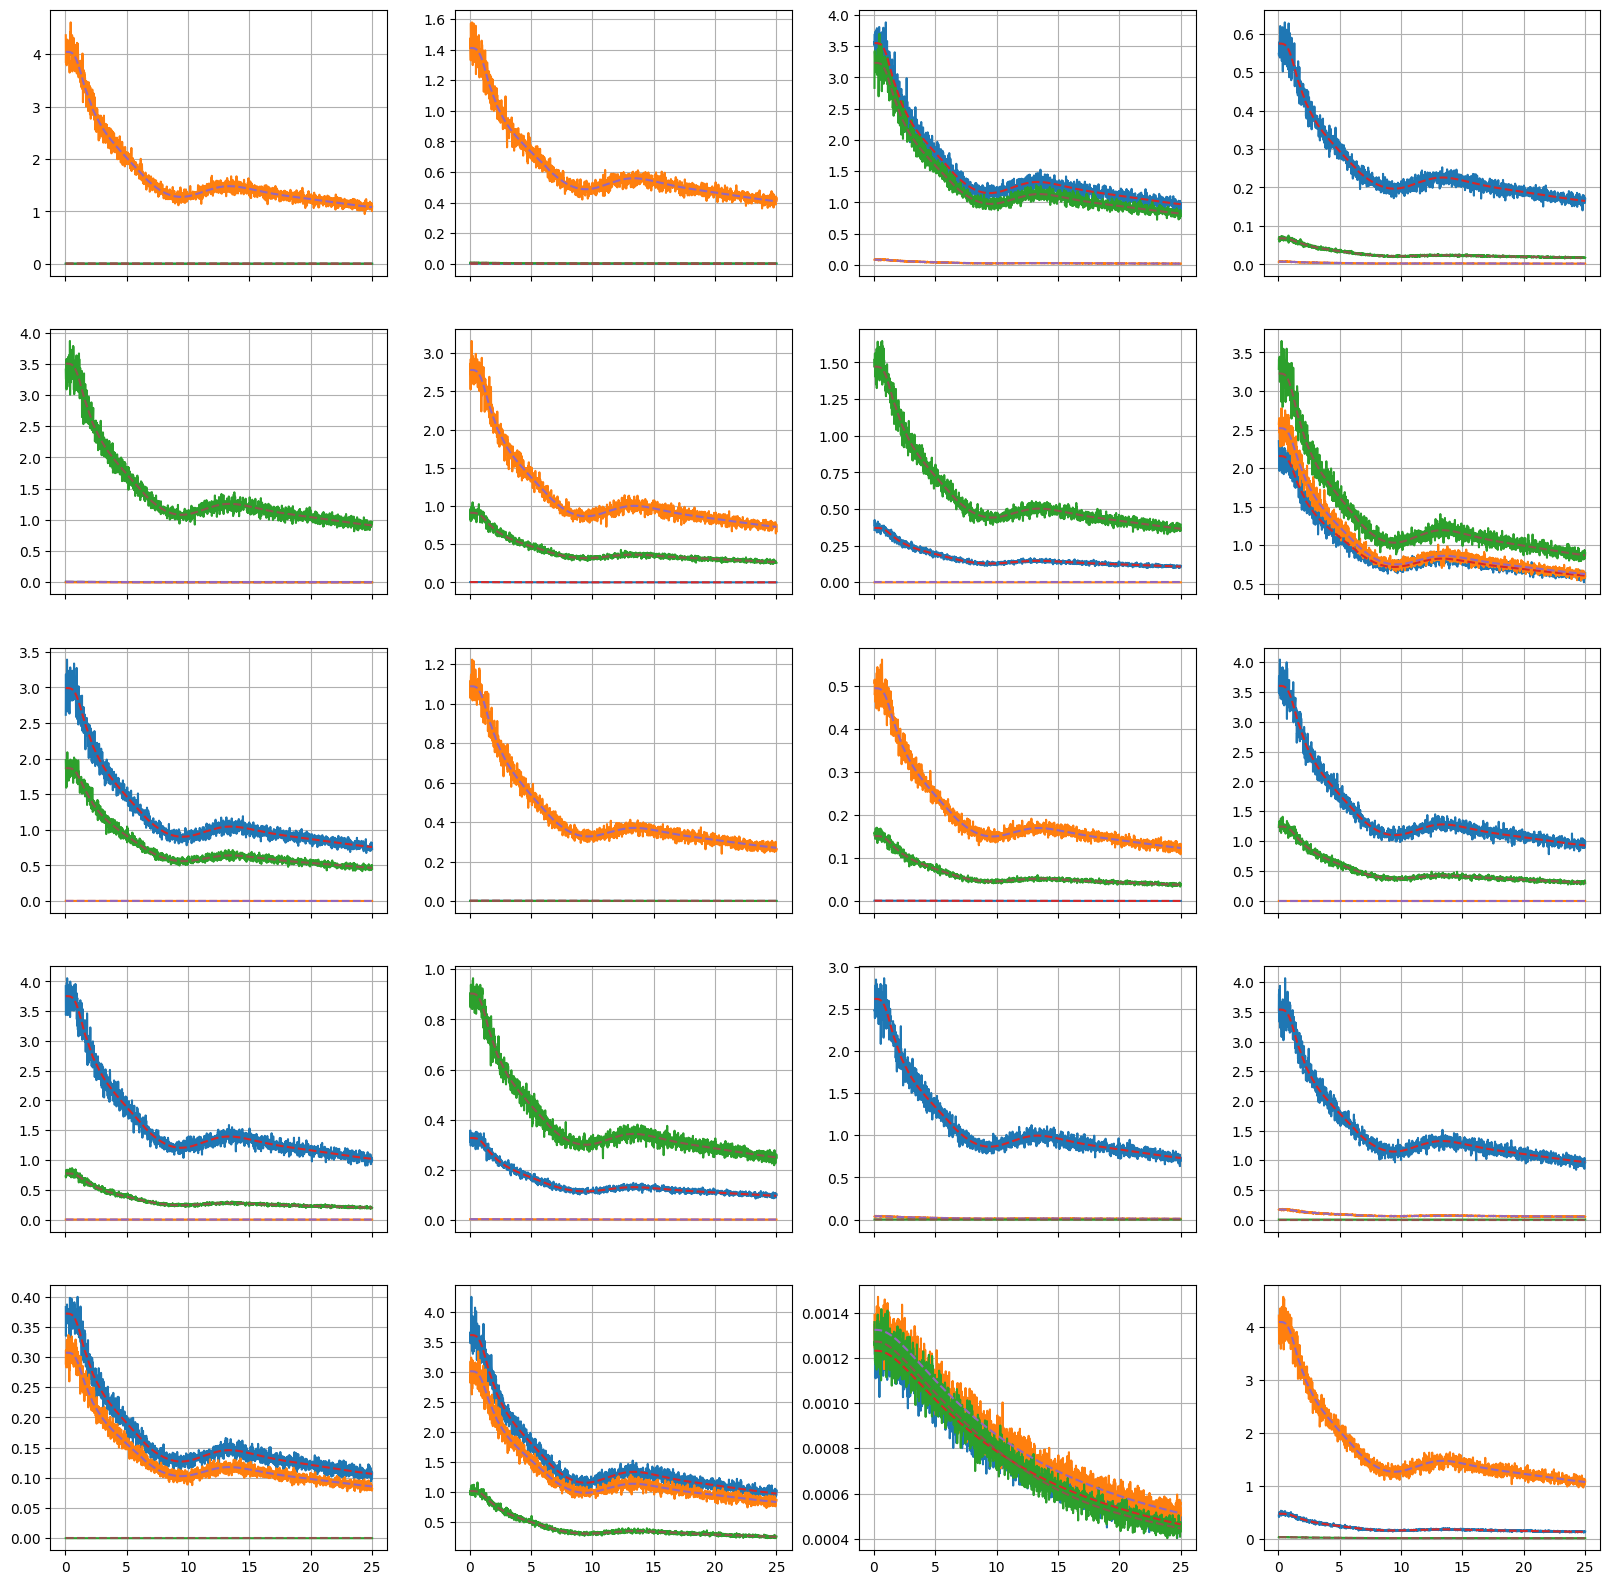

In [6]:
# # Check on the maximum
# np.max(np.abs(Xsensor_clean[j]))

ncols = 4
nrows = 5
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (5 * ncols, 4 * nrows))
axs = axs.flatten()

for kk in range(nrows * ncols):
    axs[kk].plot(new_t, Xsensor[:,:,kk].T, label='Spline')
    axs[kk].plot(times, snap_measurements[:,:,kk].T, '--', label='FOM')
    axs[kk].grid()

Let us plot the locations of the sensors

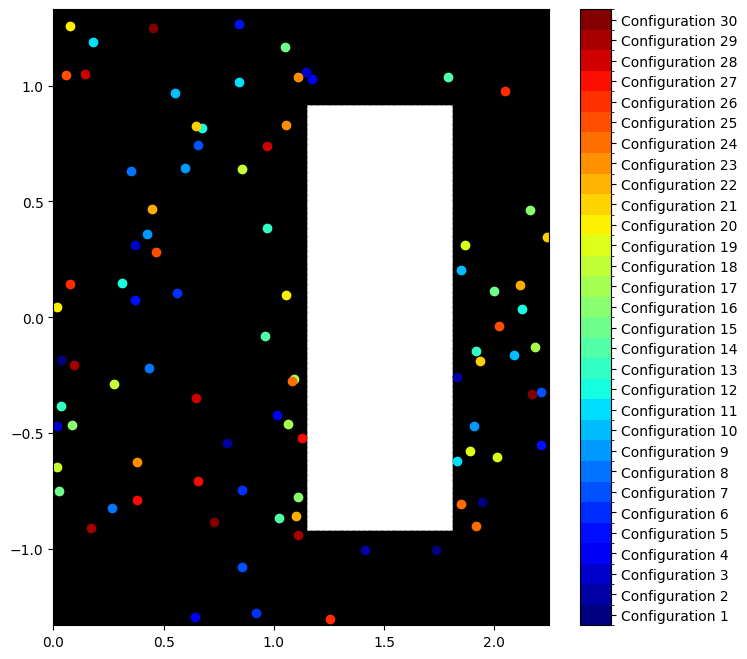

In [7]:
import matplotlib.colors as mcolors

cmap = cm.jet

colors = cmap(np.linspace(0,1,n_configurations))
fig, axs = plt.subplots(figsize=(8,8))

mesh = fun_spaces[measured_field].tabulate_dof_coordinates()
axs.scatter(mesh[:,0], mesh[:,1], c='k')
for kk in range(n_configurations):
    axs.scatter(mesh[idx_sensor_locations[:,kk].flatten(),0], mesh[idx_sensor_locations[:,kk].flatten(),1], color=colors[kk])

axs.set_xlim(min(mesh[:,0]), max(mesh[:,0]))
axs.set_ylim(min(mesh[:,1]), max(mesh[:,1]))

# Create a discrete colormap and normalization
bounds = np.linspace(0, n_configurations, n_configurations + 1)
norm = mcolors.BoundaryNorm(bounds, cm.cool.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set empty array for the ScalarMappable

# Add the discrete colorbar to the plot
cbar = plt.colorbar(sm, ax=axs, ticks=np.arange(n_configurations) + 0.5)
cbar.ax.set_yticklabels([f'Configuration {i+1}' for i in range(n_configurations)])  # Optional: custom labels

# Show the plot
plt.show()

Let us store the measurements

In [14]:
# mesh[idx_sensor_locations.T]

In [8]:
measurements = dict()
measurements['mesh'] = mesh
measurements['location'] = idx_sensor_locations
measurements['point_spread'] = point_spread
measurements['noise'] = noise_value

measurements['measured_field'] = measured_field

measurements['noisy_output'] = Xsensor

# pickle.dump(measurements, open(path_svd+'measurements_incore.data', 'wb'))
pickle.dump(measurements, open(path_svd+'measurements.data', 'wb'))